In [1]:
import numpy as np
from IPython.display import clear_output
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from GD import GD
import time
import imageio
from torch.quasirandom import SobolEngine
import sobol_seq
from utils import *
import numdifftools as nd

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.Hartmann_6(Noise, Noise_level)

# objective = f_class.Alpine(Noise, Noise_level) 
# objective = f_class.Ackley(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, dim=20)
# # objective = f_class.Rosenbrock(Noise, Noise_level)
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Levy(Noise, Noise_level, dim=10)  
# objective = f_class.Rastrigin(Noise, Noise_level, dim=6)

f = objective.func
clean_f = lambda x: f_class.Hartmann_6().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
# clean_f = lambda x: f_class.Ackley().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=20).func(x)
# clean_f = lambda x: f_class.Rosenbrock().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Levy(dim=10).func(x)
# clean_f = lambda x: f_class.Rastrigin(dim=6).func(x)
B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]


dim = objective.input_dim
print('dim: ', dim)
# print(f( np.array([dim*[1], dim*[1]])))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
dim:  6


#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [5]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

#### Sampling

In [6]:
def unique_row(X):
    """
    A functions to trim repeated rows that may appear when optimizing.
    :param X: array to trim repeated rows from
    :return: mask of unique rows
    """
    # Sort array and kep track of where things should go back to
    order = np.lexsort(X.T)
    reorder = np.argsort(order)

    X = X[order]
    diff = np.diff(X, axis=0)
    U = np.ones(len(X), 'bool')
    U[1:] = (diff != 0).any(axis=1)
    return U[reorder]

class close_data():
    def __init__(self, Xc, eps=1):
        self.Xc = Xc
        self.eps = eps
        
    # Iterable
    def __iter__(self):
        return self
    
    # Iterator
    def __next__(self):
        Xn = self.Xc + self.eps*np.random.uniform(-1, 1, self.Xc.shape)
        return Xn
    
def is_new(Xn, Xpast=None):
    if Xpast is None:
        return True
    else:
        return np.array([(i != Xn).any() for i in Xpast]).all()

def close_draw(Xc, n_random_draws=4, close=1, Xpast=None):
    # sample from a small 2d box with center given Xc, no repeated points
    X = np.zeros((n_random_draws, dim))
    X[0] = Xc
    counter = 0
    gc = close_data(Xc)
    while True:
        Xn = next(gc)
        if LA.norm(Xn - Xc) > 5e-2 and is_new(Xn, Xpast) == True:
            counter += 1
            X[counter] = Xn
        if counter == n_random_draws-1:
            break
    return X

### Grid

In [7]:
# n_Grid = dim
# G = np.zeros((dim, n_Grid))
# for i in range(dim):
#     G[i] = np.linspace(lb[i], ub[i], n_Grid)

# Grid = np.vstack( [axis.flatten() for axis in np.meshgrid(*(G[i] for i in range(G.shape[0])))] ).T
# Grid.shape

### Grid Approx Gradient

In [8]:
# # approximate the gradient
# from scipy import optimize

# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape

In [9]:
# # 3d plot of the gradient
# # approximate the gradient
# from scipy import optimize

# # optimize.approx_fprime(x, clean_Ackley_1d, eps)
# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape
# g1 = approx_grad[:, 0]
# g2 = approx_grad[:, 1]
# g1, g2

# BO

In [10]:
MAX = 200 # function observations

## Gradient-based Method

##### 1. Setup

In [11]:
# initial data
setup = 1
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))

# sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)

# X = np.vstack([X, np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))])

In [12]:
gp = GP_grad(B, Noise, Noise_level)
# gp.set_hyper(ls, var)  # if online, skip

gp.set_data(X, f(X))
ls, var = gp.optimize()
gp.set_hyper(ls, var)
gp.fit()

# w: starting point of GD
w = X[0].reshape(1, dim)
history_w = []
history_f = []

##### 2. Warm up

In [13]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
# warmup = 30
# history_warmup = []
# for i in range(1, warmup+1):
#     b = np.log(i)
#     w, fw = gp.ucb_minimize(b)
#     X = np.vstack([X, w])
    
#     print(i, end = ', ')
#     print('w: ', w, end = ', ')
#     print('f(w): ', f(w).item(), end = ', ')
#     print()
    
#     gp.add_data(w.reshape(1, dim), f(w))
    
#     if i % 5 == 0:
#         ls, var = gp.optimize()
#         print('  # Optimal (ls, var) = ', (ls, var))
#     gp.fit()
#     history_warmup.append( (w, f(w)) )
    
# X_fix = X

In [14]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
warmup = 10
history_warmup = []
for i in range(1, warmup+1):
    w = gp.Thompson_sample(n_mesh=gp.dim*100)
    gp.add_data(w.reshape(1, dim), f(w))
    if i % 5 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()    
                
    X = np.vstack([X, w])
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    history_warmup.append( (w, f(w)) )
    
X_fix = X

1, w:  [0.80986971 0.06163198 0.20187697 0.05444302 0.6013397  0.4061411 ], f(w):  -0.08004676723749564, 
2, w:  [0.81878364 0.21194051 0.6003108  0.51186454 0.81518716 0.97908169], f(w):  -0.009498500877137524, 
3, w:  [0.5067181  0.81330436 0.40964124 0.83024299 0.69869953 0.56094038], f(w):  -0.034186131224490164, 
4, w:  [0.19071926 0.84503603 0.54114085 0.9075051  0.81594604 0.29608724], f(w):  -0.18582870541625293, 
  # Optimal (ls, var) =  (0.7248362663912687, 0.05)
5, w:  [0.06115253 0.55572796 0.84527558 0.16979131 0.15269759 0.20748121], f(w):  -0.1539752890108761, 
6, w:  [0.83409393 0.83089823 0.97873485 0.28158423 0.78118426 0.05900807], f(w):  -0.05506026665947536, 
7, w:  [0.05798718 0.56890988 0.19261284 0.10955948 0.56259644 0.4663448 ], f(w):  -0.2870543743239185, 
8, w:  [0.79106104 0.91012454 0.04120495 0.81982028 0.70660734 0.0521028 ], f(w):  -0.1279442002055746, 
9, w:  [0.28154081 0.0333227  0.39561599 0.91865408 0.2600705  0.02787593], f(w):  -0.005602273550218

##### 3. Optimize via GD

In [15]:
w = gp.X[np.argmin(gp.y)]
optimizer = GD(gp, B, w, f)

from scipy import optimize
eps = np.sqrt(np.finfo(float).eps)
gp.grad(w), gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

(array([[ 0.10829299,  0.0780518 ,  0.16390377,  0.39389727, -0.33029743,
          0.26311753]]),
 array([[-0.11560587, -0.3258791 ,  0.47673385,  0.43112347, -0.78502113,
         -0.01980215]]),
 array([-5.90796452, -0.2461772 , -0.02261242, -0.79897293,  0.1119496 ,
         1.10215602]))

In [16]:
gp.optimize()
gp.fit()
np.set_printoptions(precision=4)
stall = False
cost = setup + warmup

desc = - optimizer._grad()

lr = 0.01
while cost <= MAX:
    # update w 
    if optimizer.Fail >= optimizer.stop or stall:
        lr = 0.01
        print()
        print('New Local Search: ',)
        print('Fail = ', optimizer.Fail, end = ', ')
        print('Norm = ', LA.norm(desc))
        
        # 1. random draw
#         w = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
        
#         2. UCB draw
#         w, _ = gp.ucb_minimize(cost**2)
#         gp.add_data(w.reshape(1, -1), f(w))
        
#         many UCB draws, pick the best
#         history_warmup = []
#         ucb_alternate = 20
#         for i in range(1, ucb_alternate+1):
#             b = np.log(i)
#             w, fw = gp.ucb_minimize(b)
#             if i == 1:
#                 X = w
#             else:
#                 X = np.vstack([X, w])

# #             print(i, end = ', ')
# #             print('w: ', w, end = ', ')
# #             print('f(w): ', f(w).item(), end = ', ')
# #             print()

#             gp.add_data(w.reshape(1, dim), f(w))
#             if i % 5 == 0:
#                 ls, var = gp.optimize()
#                 print('  # Optimal (ls, var) = ', (ls, var))
#             gp.fit()
#             history_warmup.append( (w, f(w)) )
            
#         w = X[np.argmin(f(X))]
            
        
        # thompson sampling
        w = gp.Thompson_sample(n_mesh=gp.dim*100)
        gp.add_data(w.reshape(1, -1), f(w)) 
        
        # tune back setting
        cost += 1
        stall = False
        
        history_w.append(optimizer.history_w)
        history_f.append([f(w).item() for w in optimizer.history_w])
        optimizer = GD(gp, B, w, f)
    else:
        lr = lr
        w, desc = optimizer.update_sample(y_best=np.min(f(gp.X)), lr=lr)
        if is_new(w, gp.X) == False:
            print('  ** hit past points')
            stall = True
            continue
            
        gp.add_data(w.reshape(1, -1), f(w))
        cost += 1
    
    
    # online hyper udpate + fitting GP with new query w
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()

    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print(cost, end = '. ')
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.6f ' % f(w).item())
    print('       d(w): ', np.squeeze(m))
    print('       s.d: ', np.squeeze(v))
    print('       g(w):', optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))
    print('       lr: %.4f' % lr)
    print()
        
print('Max Cost reached = ', cost)
history_w.append(optimizer.history_w)
history_f.append([f(w).item() for w in optimizer.history_w])

  # Optimal (ls, var) =  (0.5928427462867581, 0.06050690416504246)
12.     w:  [0.1114 0.8575 0.5521 0.5001 0.9833 0.1112],     f(w): -0.613235 
       d(w):  [-0.066  -0.5477  0.1061  0.4031 -0.3225  0.2412]
       s.d:  [0.3085 0.1224 0.3567 0.2467 0.3463 0.3583]
       g(w): [-5.9597 -0.1742 -0.0218 -0.8302  0.1132  1.0983]
       lr: 0.0100

13.     w:  [0.1126 0.8689 0.551  0.4933 0.9797 0.1077],     f(w): -0.620278 
       d(w):  [-0.0511 -0.4936  0.0365  0.3296 -0.4816  0.1779]
       s.d:  [0.3092 0.1041 0.3326 0.2218 0.1809 0.3431]
       g(w): [-6.0114 -0.0694 -0.0226 -0.9282  0.1135  1.0593]
       lr: 0.0100

14.     w:  [0.1147 0.8805 0.551  0.4846 0.9825 0.1032],     f(w): -0.628888 
       d(w):  [ 0.0684 -0.5729 -0.0592  0.0932 -0.2578  0.0657]
       s.d:  [0.2998 0.0797 0.3261 0.1679 0.097  0.3372]
       g(w): [-6.0605  0.0398 -0.0227 -1.0531  0.1152  1.0059]
       lr: 0.0100

  # Optimal (ls, var) =  (0.538763118316996, 0.05)
15.     w:  [0.1153 0.8933 0.5516 0.481

  # Optimal (ls, var) =  (0.23910395590304506, 0.37427713780283167)
39.     w:  [0.4698 0.0235 0.5186 0.2903 0.5771 0.8415],     f(w): -0.633656 
       d(w):  [ 0.0369  0.0085  0.0454  0.0223 -0.0005  0.0376]
       s.d:  [2.2403 2.5497 1.7909 2.5446 2.4215 2.3422]
       g(w): [ 1.5261 -0.5823  0.0712  0.253   4.6506  1.8938]
       lr: 0.0100

40.     w:  [0.4599 0.0189 0.5191 0.29   0.579  0.8357],     f(w): -0.648035 
       d(w):  [ 0.8541  0.5493 -0.8177 -0.0303  0.056   0.3798]
       s.d:  [1.557  2.333  0.9695 2.5443 2.4232 2.2342]
       g(w): [ 1.5496 -0.6123  0.0666  0.2712  4.7079  1.8904]
       lr: 0.0100

41.     w:  [0.4566 0.0157 0.5232 0.2852 0.5829 0.825 ],     f(w): -0.653620 
       d(w):  [ 1.0321  0.535  -0.6462 -0.3279  0.2383 -0.0722]
       s.d:  [1.1021 2.3316 0.7808 2.2241 2.3201 1.475 ]
       g(w): [ 1.5931 -0.6297  0.081   0.2374  4.7226  1.8088]
       lr: 0.0100

  # Optimal (ls, var) =  (0.23929807377692894, 0.36025809377452267)
42.     w:  [0.4513 0

  # Optimal (ls, var) =  (0.2583523502726071, 0.5447836355843035)
66.     w:  [0.3742 0.9344 0.6365 0.6464 0.8749 0.0299],     f(w): -2.751957 
       d(w):  [-2.617   1.1582  0.6417  3.0464 -1.1803  0.8864]
       s.d:  [0.787  1.1637 0.7846 0.7739 0.9274 1.2455]
       g(w): [-2.8447  2.278  -0.0604  3.9729  0.4217 -0.6496]
       lr: 0.0100

67.     w:  [0.4023 0.9205 0.6288 0.6161 0.8841 0.0259],     f(w): -2.914449 
       d(w):  [-5.3412e-01  1.8533e+00 -1.6201e-03  1.9415e+00 -7.5605e-02 -3.6666e-01]
       s.d:  [0.6914 0.5874 0.6987 0.5689 0.5216 0.9839]
       g(w): [-0.23    1.7648 -0.0668  2.443   0.452  -1.0142]
       lr: 0.0100

68.     w:  [0.4246 0.8995 0.6281 0.5931 0.8892 0.0343],     f(w): -2.966139 
       d(w):  [ 1.1861  0.7808  0.0585  0.4879 -0.0021 -0.1997]
       s.d:  [0.5551 0.59   0.7251 0.6033 0.506  0.7345]
       g(w): [ 2.0186  0.8034 -0.0677  1.1247  0.4632 -0.3327]
       lr: 0.0100

  # Optimal (ls, var) =  (0.25947791607697696, 0.5480962106547645)


95.     w:  [0.6665 0.9269 0.8215 0.7183 0.2617 0.957 ],     f(w): -0.077442 
       d(w):  [-0.0538  0.5556 -0.0346 -0.0085  0.3611 -0.1092]
       s.d:  [0.7119 1.4531 0.3044 0.8272 1.8592 0.8652]
       g(w): [ 0.0318  0.7431 -0.0027  0.0972  0.1561 -0.0278]
       lr: 0.0100

  # Optimal (ls, var) =  (0.2657810416080276, 0.49840020673569707)
96.     w:  [0.6692 0.931  0.8285 0.7194 0.2533 0.9581],     f(w): -0.075465 
       d(w):  [ 0.0305  0.7282  0.0024  0.0867  0.1329 -0.0128]
       s.d:  [0.2053 0.2637 0.2017 0.1949 0.2601 0.3324]
       g(w): [ 0.03    0.732   0.0123  0.0912  0.1423 -0.0274]
       lr: 0.0100

97.     w:  [0.6672 0.9244 0.827  0.7172 0.2585 0.9582],     f(w): -0.079930 
       d(w):  [ 0.0281  0.7378 -0.0032  0.098   0.1424 -0.0385]
       s.d:  [0.1748 0.1831 0.1742 0.1104 0.251  0.1577]
       g(w): [ 0.032   0.7649  0.0096  0.0973  0.1577 -0.028 ]
       lr: 0.0100


New Local Search: 
Fail =  4, Norm =  0.5564899461033223
98.     w:  [0.2776 0.1134 0.388

122.     w:  [0.6899 0.0846 0.0743 0.4606 0.2944 0.7146],     f(w): -1.015134 
       d(w):  [ 3.2903 -0.2002 -1.4316  2.098  -1.0011  0.5833]
       s.d:  [0.9916 1.5844 0.7501 2.1059 1.0958 1.8997]
       g(w): [ 2.7741 -0.4298 -0.9627  3.4977 -0.3554  0.8053]
       lr: 0.0100

  # Optimal (ls, var) =  (0.26980418844242204, 0.47495723743078716)
123.     w:  [0.6828 0.0805 0.0783 0.4488 0.2995 0.7134],     f(w): -1.081140 
       d(w):  [ 3.1993  0.0427 -1.2254  3.0332 -0.352   0.1921]
       s.d:  [0.9317 1.4529 0.5754 0.9388 0.3915 1.7105]
       g(w): [ 2.9081 -0.489  -1.0112  3.4694 -0.1919  0.8374]
       lr: 0.0100

124.     w:  [0.6594 0.0757 0.0865 0.4259 0.3037 0.7112],     f(w): -1.239487 
       d(w):  [ 3.4241 -0.105  -1.4812  2.9114 -0.2591  0.2956]
       s.d:  [0.6651 1.413  0.7229 0.9091 0.603  1.7339]
       g(w): [ 3.1614 -0.6019 -1.1265  3.4113 -0.0416  0.9167]
       lr: 0.0100

125.     w:  [0.6338 0.0721 0.1013 0.4101 0.3054 0.7142],     f(w): -1.388222 
       

  # Optimal (ls, var) =  (0.36148781168575334, 3.736551684355183)
150.     w:  [0.2096 0.1472 0.4609 0.2758 0.3111 0.6577],     f(w): -3.319436 
       d(w):  [ 0.1579 -0.0625 -0.2812  0.0396  0.0032 -0.0132]
       s.d:  [0.0326 0.0876 0.0294 0.0664 0.0754 0.0802]
       g(w): [ 0.1613 -0.0507 -0.2728 -0.0248 -0.0161  0.0075]
       lr: 0.0100


New Local Search: 
Fail =  3, Norm =  0.4493703595438883
151.     w:  [0.5602 0.1366 0.9202 0.3322 0.3902 0.3044],     f(w): -0.395906 
       d(w):  [ 0.7628 -1.6536  1.1502 -1.2106 -0.2662 -2.4442]
       s.d:  [4.5637 4.7479 4.2881 4.8402 4.5257 4.1701]
       g(w): [ 0.8187 -0.0857  0.8014  0.3246  1.1178 -2.2159]
       lr: 0.0100

152.     w:  [0.5577 0.1306 0.9182 0.3391 0.3886 0.3063],     f(w): -0.402583 
       d(w):  [ 0.7706 -1.6499  1.1756 -1.158  -0.2693 -2.5064]
       s.d:  [4.4262 3.7782 4.2353 3.268  4.4577 4.1398]
       g(w): [ 0.8255 -0.101   0.8134  0.3869  1.1153 -2.2447]
       lr: 0.0100

  # Optimal (ls, var) =  (0.27

  # Optimal (ls, var) =  (0.27908173197844655, 0.4272969049348022)
177.     w:  [0.1285 0.1949 0.597  0.1928 0.3668 0.5033],     f(w): -2.375540 
       d(w):  [-0.9054  0.4074  2.1091 -3.0243  3.267  -5.7116]
       s.d:  [0.7514 1.0914 0.6322 1.0197 1.0122 0.7723]
       g(w): [-1.1806  0.6882  2.2323 -2.7212  2.9343 -5.507 ]
       lr: 0.0100

178.     w:  [0.1363 0.1909 0.5871 0.2137 0.3495 0.5282],     f(w): -2.641173 
       d(w):  [-1.0799  0.505   2.1191 -2.2113  2.1335 -5.4159]
       s.d:  [0.5475 0.884  0.4677 0.6844 0.6807 0.5961]
       g(w): [-1.1701  0.7023  2.1719 -2.3051  2.2693 -5.1723]
       lr: 0.0100

179.     w:  [0.1395 0.1899 0.5827 0.2215 0.3428 0.5407],     f(w): -2.749501 
       d(w):  [-1.1547  0.6991  2.1127 -2.1015  1.8034 -4.9583]
       s.d:  [0.4424 0.6469 0.4005 0.5755 0.6137 0.3264]
       g(w): [-1.1584  0.7139  2.1281 -2.1039  1.9428 -4.8755]
       lr: 0.0100

  # Optimal (ls, var) =  (0.2792738518759105, 0.4233196386727653)
180.     w:  [0.1541 

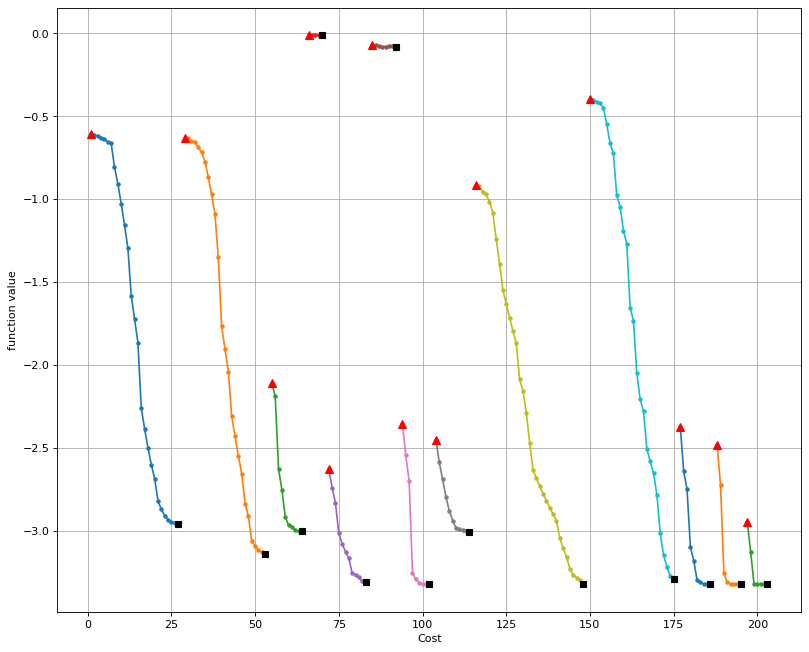

In [17]:
pl.figure(figsize=(12, 10), dpi=80)
axis = 1
for l in history_f:
    pl.plot(np.arange(axis, axis+len(l)), l, "-o", markersize=3)
    pl.plot(axis, l[0], "r^", markersize=8)
    pl.plot(axis+len(l)-1, l[-1], "ks")
    axis += len(l) + 1 # COST includes setup


pl.plot()

pl.xlabel("Cost")
pl.ylabel("function value")
pl.grid(True)

## Minima of GD

In [18]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([0.2021, 0.1495, 0.4782, 0.2745, 0.3124, 0.6571]),
 -3.3223024837270314,
 185)

In [19]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *Thompson Sampling, UCB*

In [20]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history = [(w, f(w)) for w in X]

In [21]:
cost = setup + warmup
while cost < MAX:

    # 1. Thompson Sampling
    w = gp.Thompson_sample(n_mesh=4000)
    # 2. GP_UCB
#     b = np.log(cost)
#     arg_min = np.argmin(mu.reshape(-1,1) - np.sqrt(b)*s.reshape(-1, 1)) # discrete version
#     w = Grid[arg_min]
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    
    
    
    
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = '. ')
    print('w: ', w)
    print('  f(w): ', f(w).item())
    print()
    
    history.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

11. w:  [0.0477 0.8463 0.5211 0.5097 0.667  0.6112]
  f(w):  -0.12594155905388116

12. w:  [0.4618 0.0555 0.6479 0.3863 0.064  0.8055]
  f(w):  -0.7781377985095774

  # Optimal (ls, var) =  (0.5288463491168184, 0.09488749146168007)
13. w:  [0.9577 0.1954 0.467  0.9538 0.7981 0.039 ]
  f(w):  -9.909608589681573e-05

14. w:  [0.2306 0.0233 0.6796 0.3376 0.443  0.9301]
  f(w):  -1.1574661501107149

15. w:  [0.0128 0.0517 0.6383 0.1696 0.2556 0.743 ]
  f(w):  -2.113797373144504

  # Optimal (ls, var) =  (0.4492649803335742, 0.3342889167453555)
16. w:  [0.0146 0.0106 0.4651 0.2269 0.3146 0.5769]
  f(w):  -2.534632052213056

17. w:  [0.0462 0.1496 0.4315 0.0232 0.3136 0.526 ]
  f(w):  -1.5702373445648343

18. w:  [0.0488 0.0356 0.2819 0.2666 0.2936 0.6497]
  f(w):  -2.665993003171045

  # Optimal (ls, var) =  (0.44089007509309475, 0.5025643074129851)
19. w:  [0.1311 0.0203 0.1671 0.128  0.3001 0.787 ]
  f(w):  -1.8115934475417155

20. w:  [0.0944 0.1429 0.3883 0.4507 0.0896 0.6008]
  f(w):  

90. w:  [0.1911 0.2773 0.3256 0.322  0.2786 0.6949]
  f(w):  -2.869175500503379

  # Optimal (ls, var) =  (0.2959490965245871, 0.363222725618764)
91. w:  [0.1042 0.136  0.1783 0.3255 0.3038 0.6939]
  f(w):  -2.6869271006011095

92. w:  [0.1504 0.215  0.5283 0.1956 0.2651 0.5794]
  f(w):  -2.8250144730776157

93. w:  [0.1019 0.3415 0.6043 0.2388 0.3047 0.7264]
  f(w):  -2.626301013727726

  # Optimal (ls, var) =  (0.29766686213450166, 0.3640457643022071)
94. w:  [0.1916 0.3207 0.4248 0.2709 0.3347 0.6966]
  f(w):  -2.9163776928830942

95. w:  [0.272  0.0353 0.3957 0.3349 0.3696 0.7039]
  f(w):  -2.789103100015235

96. w:  [0.3205 0.1375 0.3845 0.2275 0.1703 0.6871]
  f(w):  -2.231232975516957

  # Optimal (ls, var) =  (0.2989753705185204, 0.35894538055491304)
97. w:  [0.1876 0.1545 0.5581 0.3309 0.3647 0.5346]
  f(w):  -2.7002119682244254

98. w:  [0.2005 0.1998 0.6212 0.1831 0.2465 0.6425]
  f(w):  -2.69313638622634

99. w:  [0.055  0.2121 0.4981 0.1852 0.3592 0.6556]
  f(w):  -2.75107

  # Optimal (ls, var) =  (0.3039459830509488, 0.312464355237265)
169. w:  [0.103  0.0689 0.4117 0.2203 0.2947 0.6782]
  f(w):  -2.977395108088377

170. w:  [0.0716 0.1959 0.4747 0.2167 0.218  0.6673]
  f(w):  -2.6287372921765573

171. w:  [0.294  0.0462 0.5812 0.1767 0.3657 0.6566]
  f(w):  -2.62786594461205

  # Optimal (ls, var) =  (0.3036085565561761, 0.30976222034178624)
172. w:  [0.3027 0.2035 0.3543 0.3017 0.2771 0.7577]
  f(w):  -2.826027558876648

173. w:  [0.2585 0.1101 0.5704 0.2331 0.3612 0.7634]
  f(w):  -2.760981021807628

174. w:  [0.2134 0.0694 0.2674 0.2009 0.3374 0.6898]
  f(w):  -2.7443273010935902

  # Optimal (ls, var) =  (0.3043171134507272, 0.30839493167429005)
175. w:  [0.202  0.1044 0.4977 0.3086 0.2364 0.5897]
  f(w):  -2.8857674430833944

176. w:  [0.319  0.0914 0.4679 0.2903 0.2721 0.759 ]
  f(w):  -2.831995630185196

177. w:  [0.2649 0.1403 0.6166 0.3638 0.31   0.7793]
  f(w):  -2.593803816366977

  # Optimal (ls, var) =  (0.30434570761352253, 0.304917654231

<ipython-input-22-fb0ecf9569b4>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
<ipython-input-22-fb0ecf9569b4>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=1)


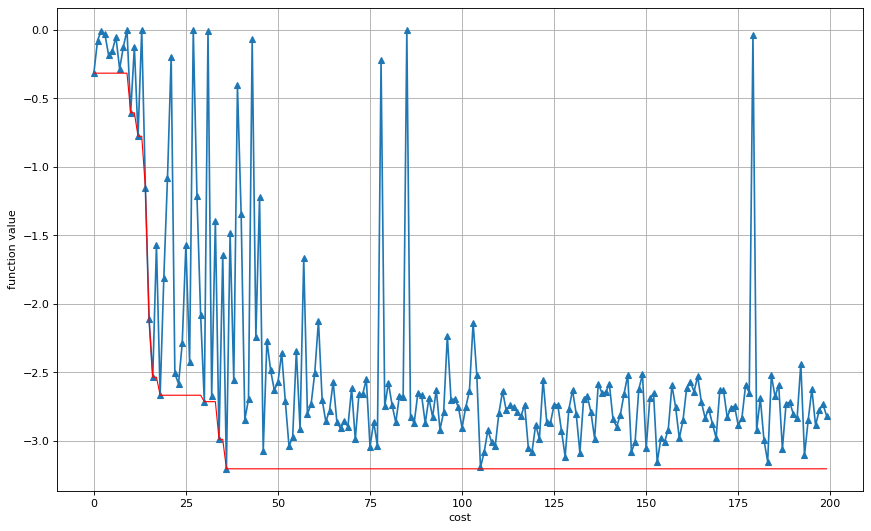

In [22]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=1)
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

## Global Minima 

In [23]:
gp.X[np.argmin(gp.y)], np.min(gp.y)

(array([0.2051, 0.0935, 0.4604, 0.2674, 0.2795, 0.6232]), -3.2024238730248125)

In [24]:
gp.get_hyper()

{'var': 0.29376072810011217, 'lengthscale': 0.3062120209817903}

### ts + GD

In [25]:
### Thompson Sampling
import os
from scipy import optimize
eps = np.sqrt(np.finfo(float).eps)

gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

w = gp.X[np.argmin(gp.y)]
history_test = [(w, f(w)) for w in X]
lr = 0.01

In [26]:
cost = setup + warmup

optimizer_warehouse = []
query_warehouse = []

while cost < MAX:
    print(cost, end = '. ')
    # 1. ts 
    w = gp.Thompson_sample(n_mesh=4000)
    optimizer = GD(gp, B, np.squeeze(w), f)
    w, desc = optimizer.update_sample(y_best=np.min(f(gp.X)), lr=lr)
    
    
    m, v = gp.posterior_full_grad('full', gp.dim*[w])
    s = np.squeeze(np.diag(v))
    if (np.squeeze(np.abs(m)) > 2*s).all():
        print('    ts val, ', f(w))
        print('    after gd')

        optimizer = GD(gp, B, np.squeeze(w), f)
        w, desc = optimizer.update_sample(y_best=np.min(f(gp.X)), lr=lr)

        mu, covar = gp.posterior(np.vstack(optimizer.history_full_w))
        mu = np.squeeze(mu)
        s = np.sqrt(np.diag(covar))

        L = np.linalg.cholesky(covar + 1e-6*np.eye(len(optimizer.history_full_w))) # LL^T = Sigma (posterior covariance)
        f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(len(optimizer.history_full_w), 1)))
        arg_min = np.argmin(f_post)
        w = optimizer.history_full_w[arg_min]
        print('    pick no. ', arg_min, end = ', ')
        
    
    # 2. GP_UCB
#     b = np.log(cost)
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))

    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    
    m, v = gp.posterior_full_grad('full', gp.dim*[w])
    s = np.squeeze(np.diag(v))
    
    
    print('w: ', w)
#     print('ind: ', arg_min)
    print('    f(w): %.6f ' % f(w).item())
    print('       d(w): ', np.squeeze(m))
    print('       s.d: ', np.squeeze(s))
    print('       g(w):', optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))
    print()
    
    history_test.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

11. w:  [[0.263  0.2293 0.715  0.4671 0.987  0.176 ]]
    f(w): -0.111953 
       d(w):  [ 0.1527 -0.5518  0.3083  0.1398 -0.1193  0.1749]
       s.d:  [0.1055 0.0962 0.1172 0.1113 0.1157 0.1255]
       g(w): [-0.0565 -0.4697  0.3474  0.1053  0.0453 -0.2459]

12. w:  [[0.0076 0.7401 0.7742 0.1651 0.9736 0.4286]]
    f(w): -0.108988 
       d(w):  [ 0.0119 -0.3424  0.4414 -0.1666 -0.0389  0.4655]
       s.d:  [0.1247 0.0948 0.1068 0.1111 0.1077 0.1148]
       g(w): [-0.3115  0.3514  0.7758  0.0805  0.0561 -0.2276]

  # Optimal (ls, var) =  (0.4380792673358395, 0.05)
13. w:  [[0.2457 0.8648 0.5353 0.3231 0.8478 0.0523]]
    f(w): -1.052370 
       d(w):  [ 0.2507  0.0527  0.2893 -0.4802 -0.3089  0.052 ]
       s.d:  [0.1752 0.2066 0.1997 0.1668 0.207  0.1999]
       g(w): [-5.5755 -0.2372 -0.0457 -5.1805  0.157   0.2863]

14. w:  [[0.4688 0.9191 0.366  0.1072 0.8665 0.0499]]
    f(w): -0.312989 
       d(w):  [ 0.9017  0.2093 -0.4988 -0.8011  0.3452  0.2576]
       s.d:  [0.1854 0.2375 0

40. w:  [[0.1017 0.3282 0.3368 0.5258 0.4558 0.1321]]
    f(w): -0.172740 
       d(w):  [-0.5298 -0.1492  0.2892  0.5202  0.0118 -0.0713]
       s.d:  [9.022  8.6086 9.4324 8.6382 9.1856 9.4252]
       g(w): [-0.5912 -0.2762 -0.1868  0.5172  0.49   -0.9055]

41. w:  [[0.0425 0.0325 0.2319 0.1173 0.0977 0.4827]]
    f(w): -0.743823 
       d(w):  [-0.0117 -0.1032 -0.009  -0.038  -0.0978  0.0391]
       s.d:  [9.7489 9.678  9.7441 9.7199 9.6875 9.7276]
       g(w): [-0.8905 -0.588  -0.8524 -2.3294 -4.9997 -2.1068]

42. w:  [[0.1356 0.8748 0.8014 0.7179 0.1867 0.0762]]
    f(w): -0.747520 
       d(w):  [-6.738  -1.1844 -0.7876  1.882   0.3133  0.4517]
       s.d:  [6.5325 8.7598 7.8401 7.1579 7.2629 9.0244]
       g(w): [-6.8089e+00 -7.9251e-02  5.6759e-03  2.1632e+00 -3.5647e-04  7.6371e-01]

  # Optimal (ls, var) =  (0.2781994396443814, 0.727255167867091)
43. w:  [[0.3847 0.9764 0.187  0.5537 0.5636 0.1462]]
    f(w): -2.401814 
       d(w):  [-0.9934  1.1453 -3.7855  0.0794 -1.2327  

69. w:  [[0.6668 0.5862 0.8294 0.7357 0.0976 0.9618]]
    f(w): -0.872929 
       d(w):  [ 0.4496  1.3568  0.074   1.2742 -0.3873  0.2156]
       s.d:  [7.5306 6.9063 8.103  7.6742 8.0349 8.0172]
       g(w): [ 0.0884  3.0083 -0.0055  0.2326 -0.1721 -0.8003]

  # Optimal (ls, var) =  (0.28463493328566464, 0.6426093158207677)
70. w:  [[0.3743 0.8148 0.9246 0.5511 0.1353 0.2708]]
    f(w): -1.445485 
       d(w):  [-0.5567 -1.7788 -0.0117  0.0336 -0.6235  6.3819]
       s.d:  [4.0644 4.7681 4.9742 4.7133 4.3245 4.8205]
       g(w): [-1.4316 -1.3937  0.0802 -0.494  -0.1678  9.0183]

71. w:  [[0.4604 0.844  0.5802 0.525  0.5307 0.0537]]
    f(w): -2.861388 
       d(w):  [ 4.311  -1.4363 -1.3868 -1.4908 -0.5061  1.9062]
       s.d:  [0.7933 0.9536 0.4377 0.7836 0.5636 1.2505]
       g(w): [ 5.4347 -1.7355 -0.0772 -2.7782  0.2771  1.173 ]

72. w:  [[0.3538 0.2221 0.3422 0.6597 0.9524 0.2192]]
    f(w): -0.071194 
       d(w):  [-0.01   -0.469  -0.1888  0.2089  0.2651  0.3319]
       s.d:  [

98. w:  [[0.4116 0.9214 0.563  0.4976 0.2219 0.1334]]
    f(w): -2.629870 
       d(w):  [ 0.3064  0.1767 -1.7574 -3.0798 -2.6526  2.9338]
       s.d:  [2.8291 2.5934 1.8902 1.9871 2.1329 2.8728]
       g(w): [ 6.5668e-01  1.7261e+00 -6.6926e-02 -3.9089e+00 -6.7091e-04  6.7729e+00]

99. w:  [[0.2832 0.4869 0.6381 0.4098 0.8583 0.9154]]
    f(w): -0.138719 
       d(w):  [ 0.0731  0.3839 -0.0764  0.1005  1.1105 -0.0135]
       s.d:  [6.2164 6.2516 6.1705 6.5959 6.1791 6.4836]
       g(w): [0.3913 0.264  0.3227 0.3687 0.1727 0.6775]

  # Optimal (ls, var) =  (0.29329174144066394, 0.5824679415163737)
100. w:  [[0.3941 0.9194 0.8715 0.5951 0.6125 0.0848]]
    f(w): -2.977080 
       d(w):  [-0.3101  1.6113  0.7826  0.7932 -0.1414  2.2587]
       s.d:  [0.5524 0.4975 0.2633 0.3221 0.2551 0.9252]
       g(w): [-1.0639  1.7508  0.0083  1.2457  0.311   3.8755]

101. w:  [[0.3348 0.7247 0.0946 0.644  0.9328 0.074 ]]
    f(w): -2.044629 
       d(w):  [-0.4547 -3.0015 -1.3793  3.1225  1.8205  1.

127. w:  [[0.4107 0.9639 0.2652 0.5098 0.613  0.0837]]
    f(w): -2.708686 
       d(w):  [ 2.1461  3.1603 -0.9354 -1.5006  0.5026  2.7624]
       s.d:  [1.6084 1.482  0.509  1.9587 0.6371 1.0846]
       g(w): [ 0.5572  3.5259 -0.1733 -3.4796  0.2942  3.4253]

128. w:  [[0.4067 0.9507 0.8699 0.6888 0.7875 0.1535]]
    f(w): -2.144393 
       d(w):  [0.3419 1.6071 0.0556 3.8231 0.9561 3.337 ]
       s.d:  [2.4131 2.5771 1.1468 1.5885 1.381  2.5656]
       g(w): [1.4572e-01 2.3339e+00 6.1145e-03 4.9136e+00 2.9217e-01 6.9218e+00]

129. w:  [[0.708  0.4793 0.2208 0.5697 0.4344 0.1466]]
    f(w): -0.189667 
       d(w):  [ 3.0034 -1.3957  1.1543  0.7698  0.525   0.6278]
       s.d:  [5.0534 4.5745 5.6257 5.4232 5.3589 5.6974]
       g(w): [ 1.658  -0.8716 -0.03    0.2117  0.1855  0.1219]

  # Optimal (ls, var) =  (0.29195438884834457, 0.5936111265523765)
130. w:  [[0.3803 0.9576 0.3279 0.441  0.345  0.0731]]
    f(w): -2.457149 
       d(w):  [-0.7791  3.1744 -0.3474 -4.1164 -1.5012  1.7745

156. w:  [[0.3785 0.8592 0.1619 0.6517 0.2389 0.0087]]
    f(w): -2.855345 
       d(w):  [-0.8476 -0.6873 -1.5831  3.9269 -1.0499 -0.0691]
       s.d:  [1.1883 1.1753 0.7823 1.739  0.4959 1.6083]
       g(w): [-2.5405 -1.0608 -0.2062  4.4416  0.066  -2.3875]

  # Optimal (ls, var) =  (0.29832741748814307, 0.593118342313135)
157. w:  [[0.35   0.1888 0.6144 0.2391 0.2698 0.8055]]
    f(w): -2.431060 
       d(w):  [ 1.4429  0.0165 -1.3725 -1.4913 -0.4707  0.4262]
       s.d:  [3.9129 4.5813 3.4433 4.0885 5.5827 4.7378]
       g(w): [ 2.3042 -0.0296  1.1124 -1.7377 -2.4262  4.5287]

158. w:  [[0.5688 0.8656 0.0067 0.504  0.9533 0.1071]]
    f(w): -1.613502 
       d(w):  [ 4.4903  0.4296 -2.549  -0.6931  1.3415  1.3338]
       s.d:  [3.5019 4.5795 4.2433 3.9067 4.2462 5.3426]
       g(w): [ 9.0004 -0.4437 -0.1401 -2.2688  0.2727  3.1148]

159. w:  [[0.2586 0.2169 0.5187 0.9897 0.1245 0.348 ]]
    f(w): -0.016526 
       d(w):  [-0.0339  0.1826 -0.0032  0.3115  0.2282 -0.1381]
       s.d:

185.     ts val,  [-3.1115]
    after gd
    pick no.  3, w:  [[0.4054 0.8917 0.3001 0.5668 0.2898 0.0334]]
    f(w): -3.140804 
       d(w):  [ 0.1681  0.7505 -0.1407 -0.5551 -0.6957  0.3718]
       s.d:  [0.3078 0.2427 0.0618 0.1329 0.0723 0.3245]
       g(w): [ 0.0845  0.4855 -0.1858 -0.4252  0.1084 -0.4912]

186. w:  [[0.3357 0.036  0.4063 0.4319 0.288  0.6257]]
    f(w): -2.360778 
       d(w):  [ 2.7206 -2.8023  1.0635  4.7548 -1.3292 -2.0982]
       s.d:  [3.2456 3.3543 2.5431 3.5252 3.162  3.6988]
       g(w): [ 1.9092 -1.8194 -0.3189  6.7848 -1.5108 -1.3279]

  # Optimal (ls, var) =  (0.30107066690117434, 0.5953818806564023)
187. w:  [[0.2188 0.2182 0.7258 0.1603 0.4341 0.9041]]
    f(w): -1.364461 
       d(w):  [-0.3714  0.3097  1.886  -2.5594  2.5127  3.0561]
       s.d:  [3.7566 3.7741 2.7554 3.5453 3.7544 4.6193]
       g(w): [ 0.2282 -0.4226  1.3617 -2.2233  5.1902  3.8555]

188. w:  [[0.1991 0.137  0.4758 0.353  0.3375 0.6294]]
    f(w): -3.091437 
       d(w):  [-1.019

<ipython-input-27-818d9ed1e3c3>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history_test)[:, 1]), "-^")
<ipython-input-27-818d9ed1e3c3>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history_test)[:, 1]), 'g', lw=1)


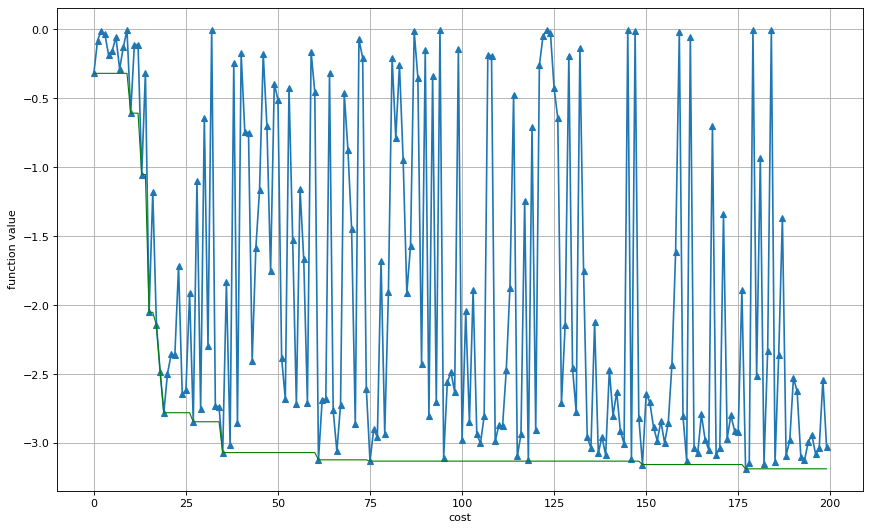

In [27]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history_test)[:, 1]), "-^")
pl.plot(np.minimum.accumulate(np.array(history_test)[:, 1]), 'g', lw=1)
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

In [28]:
gp.X[np.argmin(gp.y)], np.min(gp.y)

(array([0.1791, 0.1308, 0.3855, 0.3214, 0.3153, 0.6534]), -3.187118809724178)

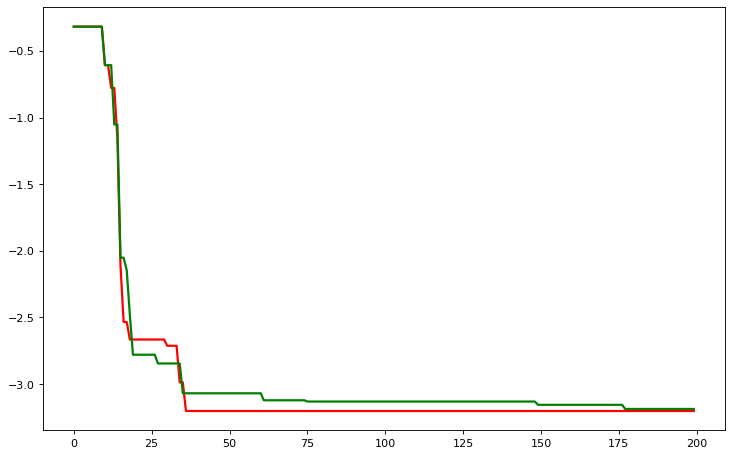

In [29]:
pl.figure(figsize=(11, 7), dpi=80)
pl.plot(np.minimum.accumulate([pair[1].item() for pair in history]), 'r', lw=2)
pl.plot(np.minimum.accumulate([pair[1].item() for pair in history_test]), 'g', lw=2)